In [ ]:

import argparse
import sys
from pathlib import Path
import os

import numpy as np
import matplotlib.pylab as plt
from matplotlib import patches as patches
from sklearn.metrics.pairwise import euclidean_distances
try:
    import joblib
except ImportError:
    from sklearn.externals import joblib
from skimage import io

!pip install -q POT

import ot

def map_img(T, img1, img2, weights1):
    """Transfer colors from img2 to img1"""
    return np.dot(T / weights1[:, np.newaxis], img2)



     |████████████████████████████████| 664 kB 5.1 MB/s 


In [ ]:
!pip install git+https://github.com/google/jaxopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/jaxopt to /tmp/pip-req-build-21hncz6n
  Running command git clone -q https://github.com/google/jaxopt /tmp/pip-req-build-21hncz6n
  Created wheel for jaxopt: filename=jaxopt-0.5-py3-none-any.whl size=129292 sha256=563b1f360de797d4adca10e4167e2eb53232d51be81e7bc6e8604c6f2612bc34
  Stored in directory: /tmp/pip-ephem-wheel-cache-styf4jao/wheels/0c/1a/50/424ccbf29b323d1aa44474c7ccfdd30127d8d6fa97527794d7
Successfully built jaxopt


In [ ]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

"""Projection with k-sparse constraints."""
from typing import Callable, Any
import jax
import jax.numpy as jnp
import jaxopt
from jaxopt._src.projection import _regularized_transport_semi_dual, projection_sparse_simplex, projection_transport
from jaxopt import LBFGS


def _max_l2_top_k(x, k, marginal_b=1.0, gamma=1.0):
  scale = gamma * marginal_b
  p = jaxopt.projection.projection_sparse_simplex(x / scale, k)
  p = jax.lax.stop_gradient(p)
  z = jnp.dot(p, x) - 0.5 * scale * jnp.dot(p, p)
  return z

_max_l2_top_k_grad = jax.grad(_max_l2_top_k)


def k_sparse_projection_transport(sim_matrix: jnp.ndarray,
                                  marginals_a: jnp.ndarray,
                                  marginals_b: jnp.ndarray,
                                  k: int,
                                  row_k_sparse: bool = False,
                                  make_solver: Callable[..., Any] = None,
                                  gamma=1.0):
  r"""Projection onto the transportation polytope with k-sparse constraints.

  Args:
    sim_matrix: similarity matrix, shape=(size_a, size_b).
    marginals_a: marginals a, shape=(size_a,).
    marginals_b: marginals b, shape=(size_b,).
    k: number of nonzeros that each row (if row_k_sparse is True) or
    column (if row_k_sparse is False) can have at most.
    row_k_sparse: if True, each row of transportation plan has at most k
      nonzeros; else, each column of transportation plan has at most k
      nonzeros.
    make_solver: a function of the form make_solver(fun),
      for creating an iterative solver to minimize fun.
    gamma: a parameter that controls the strength of squared l2 regularization.
  Returns:
    plan: transportation matrix, shape=(size_a, size_b).
  References:
    Smooth and Sparse Optimal Transport.
    Mathieu Blondel, Vivien Seguy, Antoine Rolet.
    In Proceedings of Artificial Intelligence and Statistics (AISTATS), 2018.
    https://arxiv.org/abs/1710.06276
  """

  def maxop(x, marginal_b, gamma):
    return _max_l2_top_k(x, k=k, marginal_b=marginal_b, gamma=gamma)

  maxop_vmap = jax.vmap(maxop, in_axes=(1, 0, None))
  max_grad_vmap = jax.vmap(jax.grad(maxop), in_axes=(1, 0, None))

  if row_k_sparse:
    # enforce sparsity constraint rowwise:
    marginals_a, marginals_b = marginals_b, marginals_a
    sim_matrix = sim_matrix.T

  plan = _regularized_transport_semi_dual(cost_matrix=-sim_matrix,  # pylint: disable=protected-access
                                           marginals_a=marginals_a,
                                           marginals_b=marginals_b,
                                           make_solver=make_solver,
                                           max_vmap=maxop_vmap,
                                           max_grad_vmap=max_grad_vmap,
                                           gamma=gamma,
                                            )
  if row_k_sparse:
    plan = plan.T

  return plan

In [ ]:
# From https://github.com/mblondel/smooth-ot/blob/master/examples/color-transfer/dataset.py

import os

from matplotlib import image
import numpy as np
try:
    import joblib
except ImportError:
    from sklearn.externals import joblib
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

root_dir = '/content'
DATAPATH = 'https://raw.githubusercontent.com/mblondel/smooth-ot/master/data'

if not os.path.exists(f"{root_dir}/images"):
  # Create a new directory because it does not exist
  os.makedirs(f"{root_dir}/images")

if not os.path.exists(f"{root_dir}/res"):
  # Create a new directory because it does not exist
  os.makedirs(f"{root_dir}/res")

def color_quantize(img, n_colors, name, method):
    """ cluster all colors of image """
    shape = img.shape
    img = img.reshape(-1, 3)

    if method == "kmeans":
        km = KMeans(n_clusters=n_colors, n_init=1, max_iter=300).fit(img)
        centers = km.cluster_centers_
        labels = km.labels_
    elif method == "rand":
        rng = np.random.RandomState(0)
        ind = rng.permutation(img.shape[0])
        centers = img[ind[:n_colors]]

        D = euclidean_distances(centers, img, squared=True)
        labels = D.argmin(axis=0)
    else:
        raise ValueError("Invalid quantization method")

    out = "%s/res/%s_%s_%d_colors.pkl" % (root_dir, name, method, n_colors)
    joblib.dump((shape, centers, labels), out)
    print('Saving color quantization:', out)


def load_color_transfer(img1="comunion", img2="autumn", n_colors=256,
                        method="kmeans", transpose=False):

    if transpose:
      img1, img2 = img2, img1

    # Load quantized images.
    try: # load if already saved
      shape1, centers1, labels1 = \
          joblib.load("%s/res/%s_%s_%d_colors.pkl" % (root_dir, img1, method, n_colors))
    except:
      img = io.imread('%s/%s.jpg' % (DATAPATH, img1)).astype(np.float64) / 256
      color_quantize(img, n_colors, img1, method=method)
      shape1, centers1, labels1 = \
          joblib.load("%s/res/%s_%s_%d_colors.pkl" % (root_dir, img1, method, n_colors))

    try: # load if already saved
      shape2, centers2, labels2 = \
          joblib.load("%s/res/%s_%s_%d_colors.pkl" % (root_dir, img2, method, n_colors))
    except:
      img = io.imread('%s/%s.jpg' % (DATAPATH, img2)).astype(np.float64) / 256
      color_quantize(img, n_colors, img2, method=method)
      shape2, centers2, labels2 = \
          joblib.load("%s/res/%s_%s_%d_colors.pkl" % (root_dir, img2, method, n_colors))


    m = centers1.shape[0]
    n = centers2.shape[0]

    # Prepare histograms and cost matrix.
    hist1 = np.bincount(labels1, minlength=m).astype(np.float64)
    hist1 /= np.sum(hist1)

    hist2 = np.bincount(labels2, minlength=n).astype(np.float64)
    hist2 /= np.sum(hist2)

    # Remove elements with probability 0.
    hist1 += 1e-9
    hist1 /= np.sum(hist1)
    hist2 += 1e-9
    hist2 /= np.sum(hist2)

    # Sort centers and histograms.
    ind1 = np.argsort(hist1)[::-1]
    hist1 = hist1[ind1]
    centers1 = centers1[ind1]
    inv_map1 = dict((ind1[i], i) for i in range(len(ind1)))
    labels1 = np.array([inv_map1[l] for l in labels1])

    ind2 = np.argsort(hist2)[::-1]
    inv_ind2 = np.arange(len(hist2))[ind2]
    hist2 = hist2[ind2]
    centers2 = centers2[ind2]
    inv_map2 = dict((ind2[i], i) for i in range(len(ind2)))
    labels2 = np.array([inv_map2[l] for l in labels2])

    # Prepare cost matrix.
    C = euclidean_distances(centers1, centers2, squared=True)

    return hist1, hist2, C, centers1, centers2, labels1, labels2, shape1, shape2

# Configurations

In [ ]:
n_colors = 256
row_k_sparse = False
gamma = 1.0
max_iter = 1000
img1 = 'grafiti' #'comunion'
img2 = 'rainbow-bridge' # 'autumn'

# img1 = 'comunion' #'comunion'
# img2 = 'autumn' # 'autumn'
pair = img1+'-'+img2

print("images:", img1, '|', img2)
print("n_colors:", n_colors)
print("gamma:", gamma)
print("max_iter:", max_iter)
print()


hist1, hist2, C, centers1, centers2, labels1, labels2, shape1, shape2 = \
load_color_transfer(img1=img1, img2=img2, n_colors=n_colors,
                            transpose=False)

m = len(hist1)
n = len(hist2)


T_l2_sd = ot.smooth.smooth_ot_dual(hist1, hist2, C, gamma, reg_type='l2', numItermax=max_iter)
T_ent_sd = ot.smooth.smooth_ot_dual(hist1, hist2, C, gamma, reg_type='kl', numItermax=max_iter)
T_lp = ot.emd(hist1, hist2, C)

method2T = {"l2_sd": T_l2_sd,
            "ent_sd": T_ent_sd,
            "lp": T_lp}

method2label = {"l2_sd": "Squared 2-norm",
            "ent_sd": "Entropy",
            "lp": "Unregularized"}

images: grafiti | rainbow-bridge
n_colors: 256
gamma: 1.0
max_iter: 1000



In [ ]:
from google.colab import files


In [ ]:
dataset = {'marginals_a': hist1,
          'marginals_b': hist2,
          'cost_matrix': C}

np.save('color_transfer_dataset.npy', dataset)
files.download("color_transfer_dataset.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# k-sparse OT

k: 1
Sparsity: 0.00390625
Marginal a 0.0026086438
Marginal b 0.0
Objective value: 0.13906097
Unregularized objective value: 0.1369580587215901


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

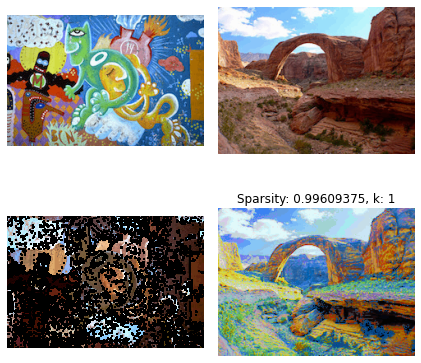

k: 2
Sparsity: 0.007019043
Marginal a 0.00047884637
Marginal b 3.909085e-14
Objective value: 0.13785863
Unregularized objective value: 0.1369580587215901


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

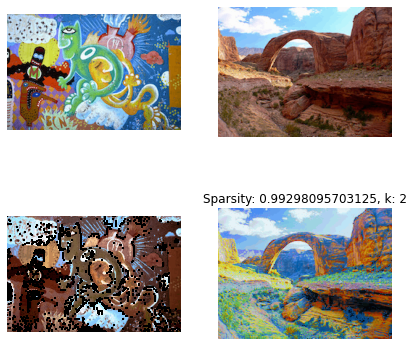

In [ ]:
method = 'k_sparse'

# for k in [1, 2, 4, 8, 16, 32, 64, 128]:
for k in [1, 2]:
  print('k:', k)
  T = k_sparse_projection_transport(sim_matrix=-C,
                            marginals_a=hist1,
                            marginals_b=hist2,
                            k=k)

  sparsity = np.sum(T > 1e-10) / T.size
  print("Sparsity:", sparsity)

  T1 = np.sum(T, axis=1)
  Tt1 = np.sum(T, axis=0)
  err_a = hist1 - np.sum(T, axis=1)
  err_b = hist2 - np.sum(T, axis=0)
  print("Marginal a", np.dot(err_a, err_a))
  print("Marginal b", np.dot(err_b, err_b))

  #print(np.sum(T * C) + 0.5 / gamma * np.dot(err_a, err_a) + 0.5 / gamma * np.dot(err_b, err_b))
  print('Objective value:', np.sum(T * C))

  T_ = ot.emd(hist1, hist2, C)
  print('Unregularized objective value:', np.sum(T_ * C))

  img1 = centers1[labels1]
  img2 = centers2[labels2]

  centers1_mapped = map_img(T, centers1, centers2, T1)
  img1_mapped = centers1_mapped[labels1]

  centers2_mapped = map_img(T.T, centers2, centers1, Tt1)
  img2_mapped = centers2_mapped[labels2]

  fig = plt.figure(figsize=(6,6))

  ax = fig.add_subplot(221)
  ax.imshow(img1.reshape(shape1))
  ax.axis("off")

  ax = fig.add_subplot(222)
  ax.imshow(img2.reshape(shape2))
  ax.axis("off")

  ax = fig.add_subplot(223)
  ax.imshow(img1_mapped.reshape(shape1))
  ax.axis("off")

  ax = fig.add_subplot(224)
  ax.imshow(img2_mapped.reshape(shape2))
  ax.axis("off")

  plt.title(f'Sparsity: {1- sparsity}, k: {k}')
  plt.tight_layout()

  # plot original and transformed images
  out = "%s/images/%s_%d_%s_%d.svg" % (root_dir, method, n_colors, pair, k)
  plt.savefig(out)
  files.download(out)
  plt.show()

# Sparse OT

gamma: 0.01
Sparsity: 0.005706787109375
Marginal a 0.00039731408401391563
Marginal b 0.00035482204896875816
Objective value: 0.13493953597480274
Unregularized objective value: 0.1369580587215901


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

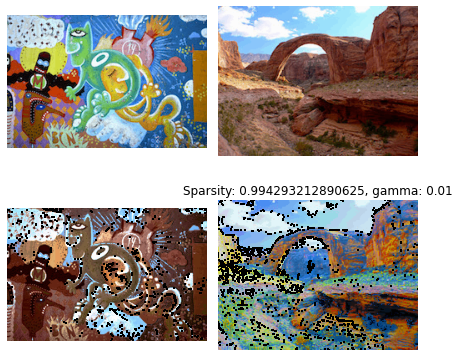

gamma: 0.1
Sparsity: 0.0082550048828125
Marginal a 1.5022756719177073e-07
Marginal b 5.72048677350067e-08
Objective value: 0.1369468566914524
Unregularized objective value: 0.1369580587215901


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

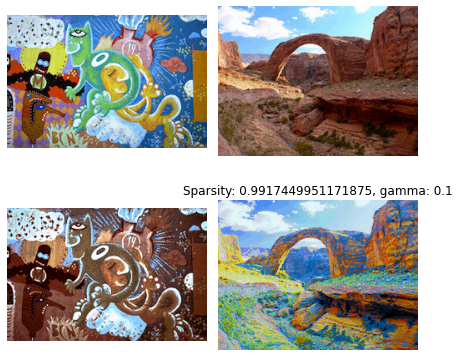

In [ ]:
method = 'sq_l2_reg'

# for gamma in [0.001, 0.01, 0.1, 1, 10]:
for gamma in [0.01, 0.1]:
  print('gamma:', gamma)
  T = ot.smooth.smooth_ot_dual(hist1, hist2, C, gamma, reg_type='l2', numItermax=max_iter)

  sparsity = np.sum(T > 1e-10) / T.size
  print("Sparsity:", sparsity)

  T1 = np.sum(T, axis=1)
  Tt1 = np.sum(T, axis=0)
  err_a = hist1 - np.sum(T, axis=1)
  err_b = hist2 - np.sum(T, axis=0)
  print("Marginal a", np.dot(err_a, err_a))
  print("Marginal b", np.dot(err_b, err_b))

  #print(np.sum(T * C) + 0.5 / gamma * np.dot(err_a, err_a) + 0.5 / gamma * np.dot(err_b, err_b))
  print('Objective value:', np.sum(T * C))

  T_ = ot.emd(hist1, hist2, C)
  print('Unregularized objective value:', np.sum(T_ * C))

  img1 = centers1[labels1]
  img2 = centers2[labels2]

  centers1_mapped = map_img(T, centers1, centers2, T1)
  img1_mapped = centers1_mapped[labels1]

  centers2_mapped = map_img(T.T, centers2, centers1, Tt1)
  img2_mapped = centers2_mapped[labels2]

  fig = plt.figure(figsize=(6,6))

  ax = fig.add_subplot(221)
  ax.imshow(img1.reshape(shape1))
  ax.axis("off")

  ax = fig.add_subplot(222)
  ax.imshow(img2.reshape(shape2))
  ax.axis("off")

  ax = fig.add_subplot(223)
  ax.imshow(img1_mapped.reshape(shape1))
  ax.axis("off")

  ax = fig.add_subplot(224)
  ax.imshow(img2_mapped.reshape(shape2))
  ax.axis("off")

  plt.tight_layout()
  plt.title(f'Sparsity: {1- sparsity}, gamma: {gamma}')

  out = "%s/images/%s_%d_%s_%f.svg" % (root_dir, method, n_colors, pair, gamma)
  plt.savefig(out)
  files.download(out)

  plt.show()

  if n_colors <= 32:
      # plot transport plan and color histogram

      def draw_blocks(ax, T):
          # find contiguous chunks between coefficients
          for k, attn_row in enumerate(T):
              brk = np.diff(attn_row)
              brk = np.where(brk != 0)[0]
              brk = np.append(0, brk + 1)
              brk = np.append(brk, T.shape[0])

              right_border = True
              for s, t in zip(brk[:-1], brk[1:]):
                  if attn_row[s:t].sum() == 0:
                      right_border = False
                      continue
                  lines = [(s, k), (t, k), (t, k + 1), (s, k + 1)]
                  lines = np.array(lines, dtype=np.float) - 0.5
                  path = patches.Polygon(lines, facecolor='none', linewidth=1.5,
                                        alpha=1, joinstyle='round',
                                        closed=not right_border,
                                        edgecolor='#999999')
                  ax.add_patch(path)
                  right_border = True

      def draw_border(ax, T):
          lines = [(0, 0), (0, T.shape[1]), (T.shape[0], T.shape[1]), (T.shape[0], 0)]
          lines = np.array(lines) - 0.5
          path = patches.Polygon(lines, facecolor='none', linewidth=1.5,
                                    alpha=1, joinstyle='round',
                                    closed=True, edgecolor='#999999')
          scatter_axes.add_patch(path)


      plt.figure(figsize=(5,5))

      scatter_axes = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
      x_hist_axes = plt.subplot2grid((3, 3), (0, 0), colspan=2,
                                    sharex=scatter_axes)

      scatter_axes.imshow(T, cmap=plt.cm.Reds, interpolation="nearest")
      scatter_axes.axis("off")

      scatter_axes.set_xlabel(name)

      draw_blocks(scatter_axes, T)
      draw_border(scatter_axes, T)

      bar_list = x_hist_axes.bar(np.arange(m), height=hist1,
                                width=(0.80 * n_colors) / m, edgecolor="#999999",
                                linewidth=1.0, color=centers1)
      x_hist_axes.axis("off")

      #if method in ("l2_primal", "l2_sp"):
      if True:
          y_hist_axes = plt.subplot2grid((3, 3), (1, 2), rowspan=2,
                                    sharey=scatter_axes)
          bar_list = y_hist_axes.barh(np.arange(n), width=hist2,
                                      height=(0.80 * n_colors) / n,
                                      edgecolor="#999999", linewidth=1.0, color=centers2)
          y_hist_axes.axis("off")

      plt.tight_layout()
      plt.subplots_adjust(wspace=0, hspace=0, bottom=0.12)
      plt.show()